<a href="https://colab.research.google.com/github/GildasTaliah/R_Basics/blob/main/Save_IIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Analyzing Credit Scores with tidymodels in R**

Welcome to Analyzing Credit Scores with tidymodels in R!

In this live training, we'll explore what differentiates consumer credit score levels and demonstrate how dimensionality reduction can retain much of the information in a dataset while reducing its size. We'll use the embed and tidymodels to build UMAP and decision tree models. We will to demonstrate the concept of information by comparing the performance of decision tree models before and after applying UMAP dimensionality reduction.

**Setup Environment**

First, we'll load the necessary packages -- tidyverse, tidymodels, embed (note we will need to install embed).

I'm assuming you've used the tidyverse before. If you have not used tidymodels or embed packages before, here's a quick summary.

tidymodels

 -- next generation of packages that incorporate tidyverse principles into machine learning and modeling.

embed

 -- contains extra recipes steps to create "embeddings" (i.e., encoding predictors)

In [11]:
install.packages('tidymodels')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘lhs’, ‘DiceDesign’, ‘sfd’, ‘patchwork’, ‘doFuture’, ‘foreach’, ‘GPfit’, ‘modelenv’, ‘dials’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’




In [12]:
# install the 'embed' package
#install.packages('embed')

# load the needed packages
library(tidyverse)
library(tidymodels)
#library(embed)

# set options to enlarge our plots
#options(repr.plot.width=12, repr.plot.height=16)

── Attaching packages ────────────────────────────────────── tidymodels 1.3.0 ──

✔ broom        1.0.7     ✔ rsample      1.2.1
✔ dials        1.4.0     ✔ tune         1.3.0
✔ infer        1.0.7     ✔ workflows    1.2.0
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.3.0     ✔ yardstick    1.3.2
✔ recipes      1.1.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()



In [13]:
# the credit score data is available here
data_url <- "https://assets.datacamp.com/production/repositories/6081/datasets/e02471e553bc28edddc1fe862666d36e04daed80/credit_score.csv"

# use read_csv to load the data
credit_df <- read_csv(data_url)

# reorder the credit_score factor levels
credit_df <- credit_df %>%
  mutate(credit_score = factor(credit_score, levels = c("Poor", "Standard", "Good")))

# look at the available features
glimpse(credit_df)

Rows: 18965 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): month, occupation, credit_mix, payment_of_min_amount, payment_beha...
dbl (17): age, annual_income, monthly_inhand_salary, num_bank_accounts, num_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 18,965
Columns: 23
$ month                    <chr> "January", "July", "April", "January", "Febru…
$ age                      <dbl> 44, 19, 39, 43, 22, 52, 32, 45, 37, 22, 26, 2…
$ occupation               <chr> "Doctor", "Doctor", "Manager", "Developer", "…
$ annual_income            <dbl> 32625.590, 31041.460, 25876.180, 15928.750, 1…
$ monthly_inhand_salary    <dbl> 2922.7992, 2501.7883, 2293.3483, 1301.3958, 1…
$ num_bank_accounts        <dbl> 0, 5, 4, 9, 7, 5, 7, 9, 1, 7, 5, 7, 9, 4, 4, …
$ num_credit_card          <dbl> 5, 2, 6, 9, 9, 5, 8, 8, 5, 7, 5, 5, 5, 5, 7, …
$ interest_rate            <dbl> 8, 5, 7, 24, 18, 5, 26, 21, 10, 25, 3, 23, 32…
$ num_of_loan              <dbl> 4, 1, 3, 4, 2, 4, 9, 2, 2, 7, 1, 3, 6, 1, 2, …
$ delay_from_due_date      <dbl> 5, 5, 5, 26, 40, 23, 62, 18, 13, 51, 10, 15, …
$ num_of_delayed_payment   <dbl> 10, 11, 15, 22, 17, 1, 18, 18, 3, 16, 7, 21, …
$ changed_credit_limit     <dbl> 2.55, 5.13, 10.29, 1.26, 6.09, 0.75, 22.13, 8…
$ num_credit_in

In [14]:
head(credit_data)

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
,<fct>,<int>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,good,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
2,good,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
3,bad,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
4,good,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
5,good,0,rent,36,26,single,no,fixed,46,107,0,0,310,910
6,good,1,owner,60,36,married,no,fixed,75,214,3500,0,650,1645


The data's dimensionality is just its number of columns. credit_df has 23 dimensions, or features -- one target variable (credit_score) and 22 predictor variables.

The target variable -- credit_score -- is categorical and has three levels: Poor, Standard, and Good. So, from a machine learning perspective we'll be dealing with a classification problem.

Our core objective is to understand what differentiates consumers with poor, standard, and good credit scores. In short, we want to explain why consumers' credit scores differ. Along the way, we'll learn about UMAP (feature extraction algorithm) and the tidymodels framework.

Exploration
Let's visually explore credit_df a little and see if we can understand why consumers have different credit scores.

NOTE:: As humans we can't visualize high-dimensional data -- we are limited to about three dimensionals (maybe four, if you add animation to capture time).

What differentiates consumer credit scores?
Let's generate a few plots to see if we can discover a few predictors that do a good job of separating the credit scores.

**Annual income density plot**

Let's start by plotting the distribution of annual income for each of the three credit score levels.

Warning message:
“Removed 199 rows containing non-finite outside the scale range
(`stat_density()`).”


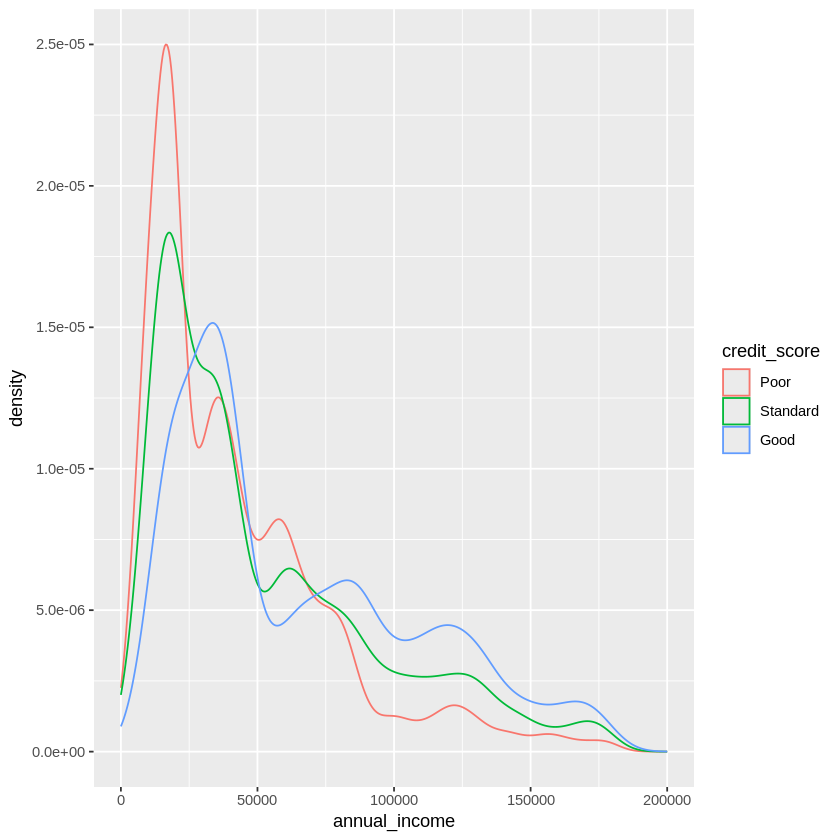

In [16]:
# plot annual_income distribution for each credit score level
credit_df %>%
  ggplot(aes(x = annual_income, color = credit_score)) +
  geom_density() +
  xlim(0, 200000)


**Takeaway**: Those with lower annual income tend to have poorer credit scores. That means that annual income contains information that helps us determine credit score.


**Age density plot**

Let's explore the age of consumers by creating a density plot of age for each of the credit score levels.

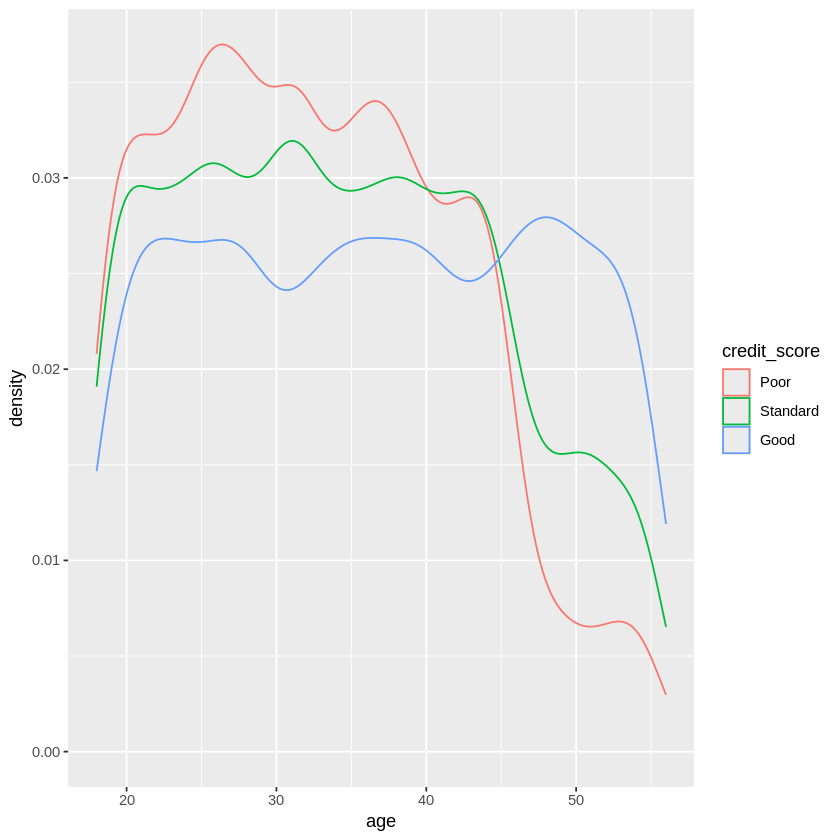

In [15]:
# plot age distribution for each credit_score level
credit_df %>%
  ggplot(aes(x = age, color = credit_score)) +
  geom_density()

**Takeaway**: Older consumers tend to have better credit score. In other words, age also contains some information that is useful for determining credit_score.







**Delay from due date vs. credit history months**

- Delay from due date = the average number of days late on payment

- Credit history months = the number of months of credit history the consumer has on record

Let's explore both of these features using a scatterplot that separates the credit score levels by color.

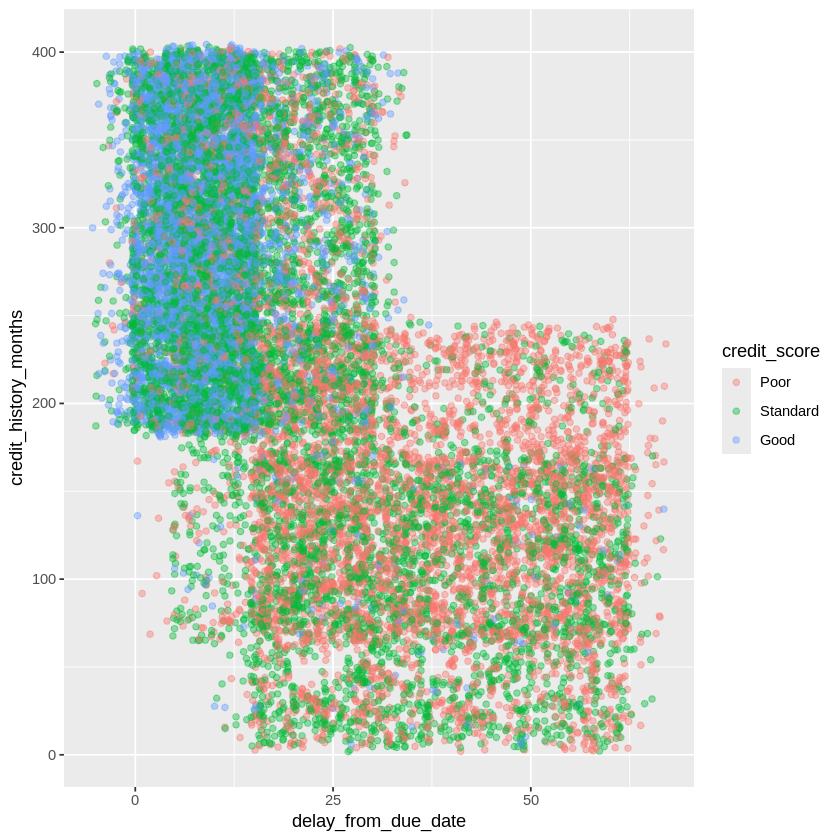

In [17]:
# plot delay_from_due_date vs credit_history_months
credit_df %>%
  ggplot(aes(x = delay_from_due_date, y = credit_history_months , color = credit_score)) +
  geom_jitter(alpha = 0.4)

Note that geom_jitter() (instead of geom_point()) prevents the data points from overlapping. This helps us to better see the colors of the three credit levels.

**Takeaway**: Both delay_from_due_date and credit_history_months contain information about credit_score.

**Credit utilization ratio (cur) vs number of credit cards**

credit utilization = the amount of their credit limit the consumer has used

$$cur = \frac{Credit Bala}{Credit Limit} \, * 100$$



Like above, let's explore credit utilization ratio and the number of credit cards a consumer has with a scatterplot.

Warning message:
“Removed 1012 rows containing missing values or values outside the scale range
(`geom_point()`).”


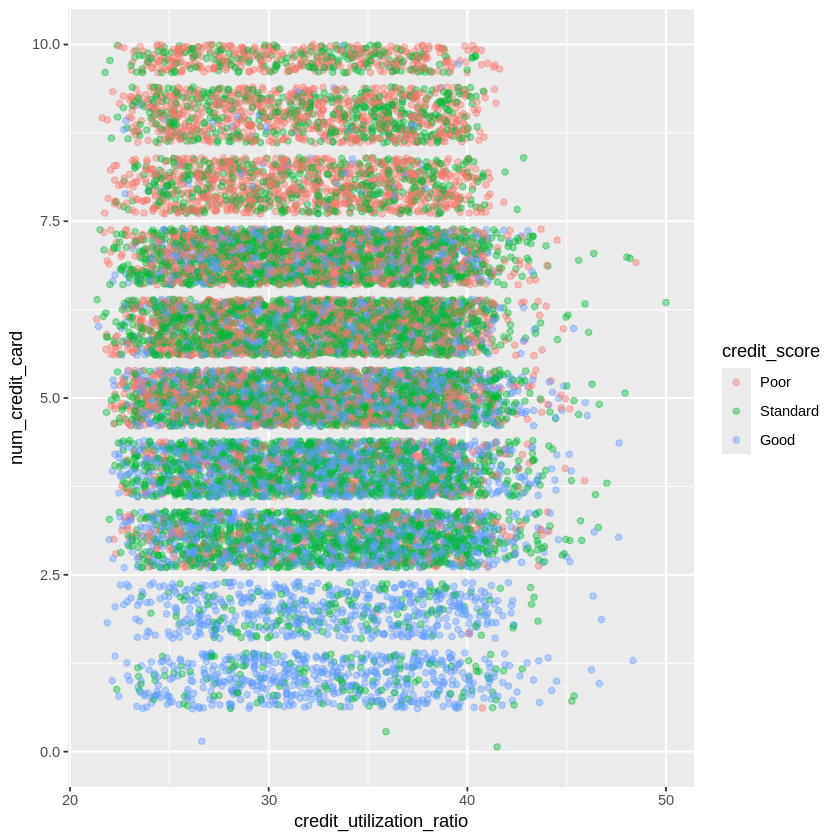

In [18]:
# plot credit_utilization_ratio vs. num_credit_card
credit_df %>%
  ggplot(aes(x = credit_utilization_ratio, y = num_credit_card, color = credit_score)) +
  geom_jitter(alpha = 0.4) +
  ylim(0, 10)

The number of credit cards separates the consumers' credit levels pretty well. Not surprisingly, those with more credit cards tend to have poorer credit. So, num_credit_card has valuable information about a consumer's credit score.



**Conclusion**

It would take a long time to visit every combination of the predictors to determine which predictors help distinguish information about consumers' credit levels. In this process, we'd discover that some predictors contain little to no information consumer's credit levels. Dropping these features would simplify the data without significantly reducing the information in the data.

Dimensionality reduction is all about eliminating the useless noise and honing in on the "signal" -- the useful information that helps us accomplish our goal in predicting the target variable.

**UMAP**

UMAP is a feature extraction technique. We will use it to reduce our 22 predicting features (dimensions) down to 2 dimensions, while still keeping as much of the original information as possible. We'll later demonstrate how much information was retained by fitting a decision tree model to predict credit score level on both the raw data and the UMAP tranformed data and observer the performance difference.

**Create the tidymodels recipe**

A recipe in tidymodels is just like a cooking recipe -- it's a series of steps you apply to the data to get a predictable, repeatable desired outcome.

Our UMAP recipe will have two steps:

- Normalize the data. We do this so that the unequal ranges of the features will not have unequal leverage in determining their importance in determing credit score level.
Apply UMAP
In the code below, we create the recipe object and then add these steps to it.

Here are some important things to notice:

- We apply step_normalize() only to the numeric predictors -- we can't normalize categorical variables and the target variable is categorical.
- We apply step_umap() to all the predictors, but not the target variable because we need to keep that separate to train the model -- UMAP can handle both continuous and categorical variables.
- We specify target variable with the outcome argument -- outcome = vars(credit_score).
- We specify that we want to reduce the data to two dimensionals with num_comp in step_umap().


In [22]:
# create the UMAP recipe with the normalize and UMAP steps
umap_recipe <- recipe(credit_score ~ ., data = credit_df) %>%
   step_normalize(all_numeric_predictors()) #%>%
   #step_umap(all_predictors(), outcome = vars(credit_score), num_comp = 2)

Train the recipe; and extract and plote the data
Now, let's apply the recipe and get the transformed data so we can plot it.

The prep() function "trains" the recipe on the data. In other words, it applies UMAP to the data.

Then we use juice() to extract the (UMAP) transformed data from the recipe, which we will plot.

In [23]:
# prepare (train) the recipe and juice (extract) the transformed data
umap_credit_df <-
  umap_recipe %>%
  prep() %>%
  juice()

Before we plot the data, take a glimpse of it. Notice the two UMAP dimensions -- data reduction complete!

In [24]:
# Take a look
glimpse(umap_credit_df)

Rows: 18,965
Columns: 23
$ month                    <fct> January, July, April, January, February, May,…
$ age                      <dbl> 0.93005233, -1.51193057, 0.44165575, 0.832373…
$ occupation               <fct> Doctor, Doctor, Manager, Developer, Developer…
$ annual_income            <dbl> -0.10415704, -0.10518648, -0.10854313, -0.115…
$ monthly_inhand_salary    <dbl> -0.4210713, -0.5463222, -0.6083332, -0.903439…
$ num_bank_accounts        <dbl> -0.14113786, -0.09744910, -0.10618685, -0.062…
$ num_credit_card          <dbl> -0.1402803, -0.1630433, -0.1326926, -0.109929…
$ interest_rate            <dbl> -0.13629914, -0.14279871, -0.13846566, -0.101…
$ num_of_loan              <dbl> 0.011530480, -0.034545278, -0.003828106, 0.01…
$ delay_from_due_date      <dbl> -0.98697207, -0.98697207, -0.98697207, 0.2741…
$ num_of_delayed_payment   <dbl> -0.08878784, -0.08434322, -0.06656475, -0.035…
$ changed_credit_limit     <dbl> -0.95883548, -0.61047753, 0.08623838, -1.1330…
$ num_credit_in

**Plot the UMAP dimensions**

Ultimately, UMAP is most useful for visualizing high-dimensional data.
Here are some nice examples
. So, let's plot those two dimensions and color code the credit levels, like before, and see how well the UMAP transformation separates the credit score levels.

In [26]:
# Create a scatterplot of the UMAP dimensions, coloring credit score level
#umap_credit_df %>%
   #ggplot(aes(x = UMAP1, y = UMAP2, color = credit_score)) +
   #geom_point(alpha = 0.2)

UMAP does a nice job separating out the credit scores, right?

But you might be wondering, "How did it separate the credit scores?" In other words, what does UMAP1 and UMAP2 mean? That's a downside to feature extraction -- the extracted dimensions are often difficult to interpret.

**Building UMAP into a Decision Tree Model**

Now, let's turn our attention to integrating dimensionality reduction into a tidymodels workflow. In this training, we do this to illustrate the concept of information and that UMAP (like other feature extraction techniques), foundationally, seeks to retain information in the data while still it.

Let's build a classification model with and without UMAP and compare their performance. The idea is that if UMAP cuts too much information, the classification model's performance will take a big hit.

**Prepare the test and train datasets**

Now, let's create the train and test sets. tidymodels (specifically, the rsample package) makes this easy.

initial_split()
 defaults to 75% for the training set and 25% for the testing set. We'll accept those defaults.

Also, notice we set the random number generator seed to make this example reproducible.

In [27]:
# set seed to make this reproducible
set.seed(3)

# Initialize the data split
credit_split <- initial_split(credit_df)

# Extract the train dataset
train <- training(credit_split)

# Extract the test dataset
test <- testing(credit_split)

**Build a tidymodels workflow without UMAP**

Now, it's time to build the base model - the model from the original credit_df data, without using UMAP.

A tidymodels workflow allows us to bundle recipe code with model building code -- it's a pipeline for pre-processing, modeling, and post-processing.

So, let's create the recipe and the model and then bundle them into a worflow object.

**Create the recipe**

In this case, it's an empty recipe -- we don't want to modify the original credit_df data. Notice that we pass the recipe object a formula -- this basically says, "Use credit_score as the target variable".

In [28]:
# create an empty recipe object with credit_score as the target variable
dt_recipe <- recipe(credit_score ~ ., data = train)

**Create the decision tree model**

The parnsip package in tidymodels provides a simple-to-use interface for creating models. Let's instantiate a decision tree model for classification.

In [29]:
# create a decision tree model for classification
dt_model <- decision_tree(mode = "classification")

Notice we specify mode = "classification" because many decision tree algorithms (e.g., random forest, CART, ID3) can perform regression.

> NOTE: decision_tree() abstracts away model implementation details. You can specifiy the implementation you use with the engine argument.

Add recipe an model to work flow

In [30]:
# create a workflow and add the recipe and model to it
dt_workflow <- workflow() %>%
   add_recipe(dt_recipe) %>%
   add_model(dt_model)

Train the model
To be precise, we are fitting the recipe and the model on the training data set when we call this code.

In [36]:
# train the model (that is, fit the workflow to the train data)
dt_fit <- dt_workflow %>%
   fit(data = train)

Predict the test data

In [32]:
# predict the test data with the trained model
predict_df <- test %>%
   bind_cols(predict = predict(dt_fit, test))

**Evaluate the model's test predictions**
The yardstick package in tidymodels provides an interface to evaluate models with a variety of metrics. Here we will use the F-measure, which combines the model recall and precision.

In [37]:
# Test results: XBG
xgbreg_aug <- augment(dt_fit, new_data = test)

#xgbclass_aug <- augment(xgbclassfinal_fit, new_data = test_class)

bind_rows( xgbreg_aug |> accuracy(truth = credit_score, .pred_class),
           xgbreg_aug |> roc_auc(truth = credit_score, .pred_class))

ERROR: [1m[33mError[39m in `roc_auc()`:[22m
[1m[22m[33m![39m The number of levels in `truth` (3) must match the number of columns
  supplied in `...` (1).


In [33]:
# Calculate the F-measure of the test predictions
f_meas(predict_df, credit_score, .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
f_meas,macro,0.6215201


And that will serve has our benchmark comparison for UMAP. Remember, we are just getting a feel for how much information UMAP retained as it reduced the data to two dimensions.

**Build a tidymodel workflow with UMAP* or try PCA*
Now, let's repeat the above process. The only difference is the recipe.

We'll add the same two steps we used above when we plotted the UMAP data -- step_normalize() and step_umap() -- to preprocess the data before building the decision tree model.

NOTE: This decision tree model will only be trained on two predictors -- UMAP1 and UMAP2; whereas, the prior model was trained on 22 predictors.



In [ ]:
# create the UMAP recipe
dt_recipe <- recipe(credit_score ~ ., data = train) %>%
   step_normalize(all_numeric_predictors())  %>%
   step_umap(all_numeric_predictors(), outcome = vars(credit_score), num_comp = 2)

# create the decision tree model
dt_model <- decision_tree(mode = "classification")

# add the recipe and model to the workflow
dt_workflow <- workflow() %>%
   add_recipe(dt_recipe) %>%
   add_model(dt_model)

# train the model
dt_fit <- dt_workflow %>%
   fit(data = train)

# predict the test set
predict_df <- test %>%
   bind_cols(predict = predict(dt_fit, test))



# evaluate the model performance on the test set
f_meas(predict_df, credit_score, .pred_class)

With UMAP, the model's performance (based on the F-measure) dropped to 0.548 (from 0.622). So, not surprisingly, we lost some information through the UMAP reduction. But for going from 22 to 2 dimensions, the model based on UMAP performs pretty well compared to the model based on the original credit_df data. Depending on the

In [ ]:
# the end